#### Copyright 2020 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License")
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

 https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Reformer: Image Generation [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/trax/blob/master/trax/models/reformer/image_generation.ipynb)

This notebook was designed to run on TPU.

To use TPUs in Colab, click "Runtime" on the main menu bar and select Change runtime type. Set "TPU" as the hardware accelerator.

In [0]:
# Grab newest JAX version.
!pip install --upgrade -q jax==0.1.57 jaxlib==0.1.37

# Make sure the Colab Runtime is set to Accelerator: TPU.
import requests
import os
if 'TPU_DRIVER_MODE' not in globals():
  url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver0.1-dev20191206'
  resp = requests.post(url)
  TPU_DRIVER_MODE = 1

# The following is required to use TPU Driver as JAX's backend.
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
print(config.FLAGS.jax_backend_target)

In [0]:
!pip install --upgrade -q gin git+https://github.com/google/trax.git@v1.2.0

from tensorflow.compat.v1.io.gfile import GFile
import gin
import os
import jax
import trax
from trax.supervised import inputs

import numpy as onp
import jax.numpy as np

from scipy.special import softmax

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt

## Load example data and model

In [0]:
# Normally we train on the full imagenet64 training set, which is quite large so
# we won't be loading it from this notebook. Instead, let's just load a few PNG
# images to use in our data pipeline.
DATA = []
for i in range(8):
  img = plt.imread(GFile('gs://trax-ml/reformer/img{}.png'.format(i), 'rb'))
  # Convert from RGBA floating-point to RGB integer representation.
  img = onp.asarray(img[:, :, :3] * 255, dtype=onp.int32)
  DATA.append(img)

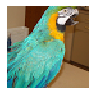

In [0]:
# We can examine one of the images to make sure we've loaded it correctly.
plt.figure(figsize=(1.5, 1.5))
plt.axis('off')
plt.imshow(DATA[0])

In [0]:
# We'll be using a pre-trained 12-layer Reformer model.
# First, load the config (which sets all needed hyperparameters).
!gsutil cp gs://trax-ml/reformer/config.gin ./config.gin
gin.parse_config_file('./config.gin')

In [0]:
# Now we construct a ReformerLM instance and load the pre-trained weights.
# The 'predict' mode configures the model to accept single tokens at a time,
# instead of feeding in a complete image all at once.
model_infer = trax.models.ReformerLM(mode='predict')
model_infer.init_from_file('gs://trax-ml/reformer/model.pkl', weights_only=True)

## Sample from the model

In [0]:
# Prepare a jitted copy of the model.
jit_model_infer = trax.layers.base._accelerate(
    model_infer._forward_internal, trax.math.device_count())

# Construct an initial state for sampling, and replicate both the state and the
# model weights to all devices. The TPU colab runtime has 8 TPU cores, so we can
# use it to sample 8 images in parallel.
model_weights = trax.layers.for_n_devices(
    model_infer.weights, trax.math.device_count())
infer_state = model_infer.new_weights_and_state(
    trax.supervised.trainer_lib.ShapeDtype((1,1), dtype=np.int32))[1]
infer_state = trax.layers.for_n_devices(infer_state, trax.math.device_count())

In [0]:
def sample(prompt=None, length=64*64*3):
  """Sample from the ReformerLM model"""
  # Token id 0 is the equivalent of a "start" token
  cur_inputs = np.zeros((trax.math.device_count(), 1, 1), dtype=np.int32)

  cur_state = infer_state
  rngs = trax.math.random.split(trax.math.random.get_prng(0), trax.math.device_count())
  all_samples = []

  if prompt is not None:
    flat_prompt = []
    plt.figure(figsize=(10, 10*8))
    for i, img in enumerate(prompt):
      img = img.reshape((-1, 64, 3))[:32, :, :]
      plt.subplot(1, 8, i+1)
      plt.axis('off')
      plt.imshow(img, aspect='equal')
      flat_prompt.append(img.reshape((-1,)))
    prompt = onp.stack(flat_prompt, 0)
    plt.show()

  for iteration in range(length):
    if iteration % (2 * 64 * 3) == 0 and all_samples and (
        prompt is None or iteration > prompt.shape[1]):
      plt.figure(figsize=(10, 10*8))
      for i, img in enumerate(onp.stack(all_samples, -1)):
        plt.subplot(1, 8, i+1)
        plt.axis('off')
        plt.imshow(img.reshape((-1, 64, 3)), aspect='equal')
      plt.show()
    logits, cur_state = jit_model_infer(
        cur_inputs,
        model_weights,
        cur_state,
        rngs)
    
    if prompt is not None and iteration < prompt.shape[1]:
      cur_samples = onp.array(prompt[:, iteration], dtype=int)
    else:
      logits = onp.array(logits)[:,0,0,:]
      probs = onp.exp(logits)
      cur_samples = [onp.random.choice(probs.shape[-1], p=probs[i,:])
                    for i in range(probs.shape[0])]
      cur_samples = onp.array(cur_samples, dtype=int)
    all_samples.append(cur_samples)

    cur_inputs = np.array(cur_samples[:,None,None])
  all_samples = onp.stack(all_samples, -1)
  
  return all_samples

Now we're ready to sample from the pre-trained Reformer model. Unlike during training, sampling processes the images one pixel and channel value at a time. If a single step takes a tenth of a second, the full 12288 steps for generating an image will take ~20 minutes. However, sampling is easy to parallelize; the TPU colab runtime has 8 cores so we can sample 8 images in parallel.

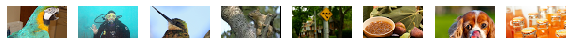

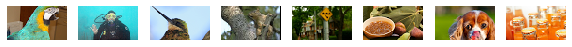

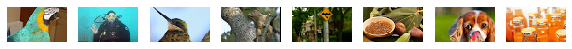

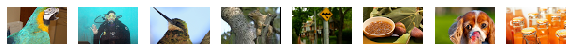

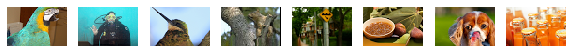

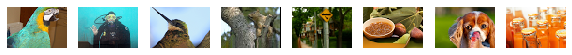

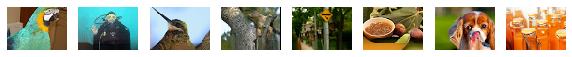

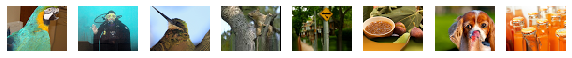

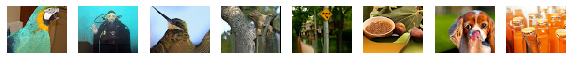

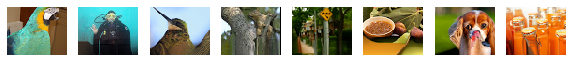

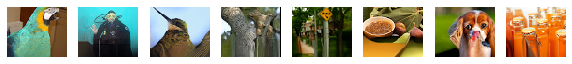

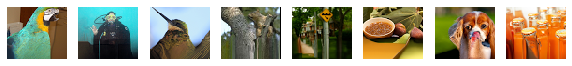

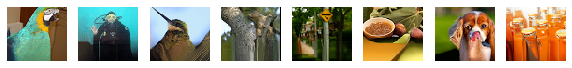

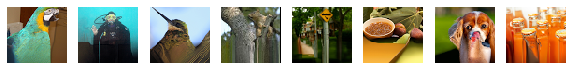

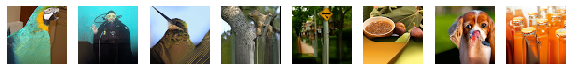

In [0]:
# Now, let's sample.
samples = sample(DATA[:trax.math.device_count()])